In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv('credit_card_data.csv', skiprows = 1)

df.set_index('ID', inplace=True)

df.head()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [9]:
df.columns = df.columns.str.lower()
df.rename({'default payment next month': 'default'}, axis= 1, inplace= True)

In [1]:
# no nulls, 30k data points
# df.describe().iloc[:,5:]

<h3> Data Cleaning </h3>

In [10]:
# drop the education = 0 and marriage = 0 they are likely unknowns
# we're losing 14 + 54 data points

df.drop(df[df['education']==0].index, inplace=True)
df.education.value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
Name: education, dtype: int64

In [11]:
df.drop(df[df['marriage']==0].index, inplace=True)
df.marriage.value_counts()

2    15954
1    13655
3      323
Name: marriage, dtype: int64

In [14]:
# calculate payment as a % of prev months balance
for i in range(1,6):
    df[f'pay%_{i}'] = df[f'pay_amt{i}'] / df[f'bill_amt{i+1}']

In [15]:
df.head()

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,pay%_1,pay%_2,pay%_3,pay%_4,pay%_5
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,1,0.000000,1.000000,NaN,NaN,NaN
2,120000,2,2,2,26,-1,2,0,0,0,...,1000,1000,0,2000,1,0.000000,0.372856,0.305623,0.289436,0.000000
3,90000,2,2,2,34,0,0,0,0,0,...,1000,1000,1000,5000,0,0.108220,0.110628,0.069779,0.066899,0.064313
4,50000,2,2,1,37,0,0,0,0,0,...,1200,1100,1069,1000,0,0.041465,0.040961,0.042382,0.037985,0.036180
5,50000,1,2,1,57,-1,0,-1,0,0,...,10000,9000,689,679,0,0.352734,1.023608,0.477555,0.470072,0.036015


In [18]:
# education: group 4,5,6 into one bin as these are all unkowns

df['education'] = df['education'].map(lambda x: 4 if x >= 4 else x)
df.education.value_counts()

In [21]:
df['arrears_1'] = df['pay_0'].map(lambda x: 3 if x >= 3 else x)

# pay_i: group 3 or more arrears into a new series
for i in range(2,7):
    df[f'arrears_{i}'] = df[f'pay_{i}'].map(lambda x: 3 if x >= 3 else x)

In [23]:
df.head()

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,pay%_2,pay%_3,pay%_4,pay%_5,arrears_2,arrears_3,arrears_4,arrears_5,arrears_6,arrears_0
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,1.000000,NaN,NaN,NaN,2,-1,-1,-2,-2,2
2,120000,2,2,2,26,-1,2,0,0,0,...,0.372856,0.305623,0.289436,0.000000,2,0,0,0,2,-1
3,90000,2,2,2,34,0,0,0,0,0,...,0.110628,0.069779,0.066899,0.064313,0,0,0,0,0,0
4,50000,2,2,1,37,0,0,0,0,0,...,0.040961,0.042382,0.037985,0.036180,0,0,0,0,0,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,1.023608,0.477555,0.470072,0.036015,0,-1,0,0,0,-1


<h3> TEMP -> TRYING to figure out arrears relating to default </h3>

In [23]:
df.pay_0.value_counts()

 0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: pay_0, dtype: int64

In [38]:
df['default'].value_counts()

0    23364
1     6636
Name: default, dtype: int64

In [42]:
df[df['default']==0].pay_0.value_counts(normalize=True)

 0    0.549949
-1    0.202534
 1    0.104263
-2    0.102465
 2    0.035225
 3    0.003338
 4    0.001027
 5    0.000556
 8    0.000342
 6    0.000214
 7    0.000086
Name: pay_0, dtype: float64

In [41]:
df[df['default']==1].pay_0.value_counts(normalize=True)

 0    0.284509
 2    0.277878
 1    0.188668
-1    0.143761
-2    0.055003
 3    0.036769
 4    0.007836
 5    0.001959
 8    0.001658
 7    0.001055
 6    0.000904
Name: pay_0, dtype: float64

In [24]:
df.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'default'],
      dtype='object')

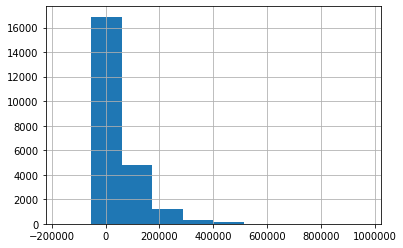

In [60]:
df[df['default']==0]['bill_amt1'].hist();